In [1]:
import numpy as np
import pandas as pd
import random
import os
import tqdm.notebook as tqdm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
#from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import log_loss
#from prettytable import PrettyTable
import pickle
%matplotlib inline

###### Reading the data files 

In [4]:
datafile =  "final_dataset.csv"
df = pd.read_csv(datafile, index_col=False)


In [6]:
print('Dataframe shape is ',df.shape)
df.head()

Dataframe shape is  (12794627, 85)


,Unnamed: 0,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,624,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:32 AM,3974862,29,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
1,625,192.168.4.118-203.73.24.75-4504-80-6,192.168.4.118,4504,203.73.24.75,80,6,12/06/2010 08:34:36 AM,63,1,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
2,626,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:36 AM,476078,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
3,627,192.168.4.118-203.73.24.75-4505-80-6,192.168.4.118,4505,203.73.24.75,80,6,12/06/2010 08:34:37 AM,151,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos
4,628,192.168.4.118-203.73.24.75-4506-80-6,192.168.4.118,4506,203.73.24.75,80,6,12/06/2010 08:34:37 AM,472507,2,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ddos


In [10]:
df.shape

(12794627, 84)

In [8]:
##get rid of unnamed column

df.drop('Unnamed: 0',axis=1,inplace=True)
df.columns


Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [11]:
df.describe()

,Src Port,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,...,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07,1.279463e+07
mean,3.707054e+04,1.464290e+04,7.828588e+00,8.219593e+06,2.719636e+01,4.974281e+00,1.125726e+03,3.264955e+03,2.922581e+02,7.095577e+00,...,2.414145e+01,8.117674e+00,1.369699e+05,6.936347e+04,2.049868e+05,9.030539e+04,3.119925e+06,1.093532e+05,3.215790e+06,3.019046e+06
std,2.521985e+04,2.306383e+04,4.206168e+00,2.477327e+07,1.720577e+03,2.509204e+02,5.479157e+04,5.387678e+05,3.931045e+02,1.974606e+01,...,1.711587e+03,9.138129e+00,2.301480e+06,1.399946e+06,3.050190e+06,1.934856e+06,1.219261e+07,1.414693e+06,1.244476e+07,1.206527e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.430000e+02,8.000000e+01,6.000000e+00,1.262000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.059200e+04,8.000000e+01,6.000000e+00,3.206500e+04,2.000000e+00,1.000000e+00,4.200000e+01,1.120000e+02,4.000000e+01,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,5.621500e+04,3.855000e+04,6.000000e+00,4.159736e+06,4.000000e+00,4.000000e+00,9.350000e+02,3.580000e+02,6.770000e+02,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,6.553500e+04,1.700000e+01,1.200000e+08,3.096280e+05,2.919230e+05,9.908096e+06,6.554527e+08,2.336000e+04,1.472000e+03,...,3.096280e+05,4.800000e+01,1.132691e+08,7.523241e+07,1.132691e+08,1.132691e+08,1.199997e+08,7.639395e+07,1.199997e+08,1.199997e+08


In [15]:
#Lets Check for data imbalance 
print(df['Label'].value_counts())


ddos      6472647
Benign    6321980
Name: Label, dtype: int64


In [2]:
#Choosing anonther file for imbalanced data 
imbalanced_data_file = "unbalaced_20_80_dataset.csv"
df = pd.read_csv(imbalanced_data_file, index_col=False)

In [3]:
df.shape

(7616509, 85)

In [4]:
print(df['Label'].value_counts())

Benign    6321980
ddos      1294529
Name: Label, dtype: int64


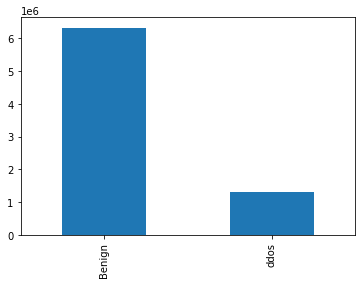

In [5]:
labels = df['Label'].value_counts()

labels.plot(kind='bar')

In [6]:
print(df['Flow Byts/s'].value_counts())


0.000000e+00    2061579
inf               18067
3.100000e+07      13988
1.033333e+07       7563
7.700000e+07       4266
                 ...   
2.595139e+02          1
2.625376e+03          1
3.009738e+02          1
3.051154e+02          1
2.663142e+03          1
Name: Flow Byts/s, Length: 3542914, dtype: int64


In [7]:
print(df['Flow Pkts/s'].value_counts())

2.000000e+06    61275
inf             47755
6.666667e+05    24041
1.000000e+06    16211
7.692308e+04    14715
                ...  
2.765869e+01        1
6.936328e+00        1
2.017616e+00        1
8.702756e+00        1
8.083433e-02        1
Name: Flow Pkts/s, Length: 3106274, dtype: int64


In [5]:

df.replace([np.inf, -np.inf], np.nan,inplace=True)

In [6]:
#Check for missing values in data and replace with mean of that column 
nulls_sum = df.isnull().sum()
colums_with_null =[]
for i,val in nulls_sum.items():
    if(val!=0):
        print('Column name : ' + i +'has ' + str(val) + ' null values .')
        colums_with_null.append(i)
print(colums_with_null)
for col in colums_with_null:
    df[col].fillna(df[col].mean(),inplace=True)
        
        

Column name : Flow Byts/shas 47755 null values .
Column name : Flow Pkts/shas 47755 null values .
['Flow Byts/s', 'Flow Pkts/s']


#### ** Data Clen up now to drop the columns which are not needed as there are ~ 85 columns 

In [7]:
##get rid of unnamed column

df.drop('Unnamed: 0',axis=1,inplace=True)
df.columns

Index(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol',
       'Timestamp', 'Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts',
       'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE 

In [8]:
#Check Columns with single values as they can be dropped from modelling further 

drop_col = []

for col in (df.columns):
    if len(df[col].unique())==1:
        drop_col.append(col)
    
print(drop_col)    


['Fwd URG Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg']


In [9]:
Target = df['Label']

In [10]:
#dropping Label as its our taget and Flow ID as its combination of several other columns 
drop_col.extend(['Label','Flow ID'])

In [11]:
print(drop_col)

['Fwd URG Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Label', 'Flow ID']


In [10]:
## Feature Engineering 
#All features having a standard deviation of 0 are selected and will be dropped subsequently.
stats = df.describe()
std = stats.loc['std']
features_no_variance = std[std == 0.0].index
pd.Series(features_no_variance).sort_values()

7    Bwd Blk Rate Avg
5      Bwd Byts/b Avg
6      Bwd Pkts/b Avg
1       Bwd URG Flags
4    Fwd Blk Rate Avg
2      Fwd Byts/b Avg
3      Fwd Pkts/b Avg
0       Fwd URG Flags
dtype: object

The above list is same as we already ahve for drop columns , no new columsn added to drop list.

In [11]:
#Lets look at  'Timestamp' to see how much that column can help in analysis
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
#df['Timestamp'].describe(datetime_is_numeric=True)


In [14]:
time_df = df['Timestamp'].groupby([df['Label'],df['Timestamp'].dt.date]).agg({'count'})
time_df = time_df.reset_index()
time_df

,Label,Timestamp,count
0,Benign,2017-03-07,352287
1,Benign,2017-04-07,71644
2,Benign,2018-02-20,5898049
3,ddos,2010-06-13,1911
4,ddos,2010-12-06,8887
5,ddos,2018-02-15,10690
6,ddos,2018-02-16,723196
7,ddos,2018-02-20,115709
8,ddos,2018-02-21,180242
9,ddos,2018-02-22,253894


In [12]:
# timestamp and dst_port are agnostic 
print(drop_col)
drop_col.extend(['Timestamp','Dst Port'])
print(drop_col)


['Fwd URG Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Label', 'Flow ID']
['Fwd URG Flags', 'Bwd URG Flags', 'Fwd Byts/b Avg', 'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Label', 'Flow ID', 'Timestamp', 'Dst Port']


In [13]:
#Dropping all these columns 
print("\noriginal Shape of data : "  ,df.shape )
df_reduced = df.drop(drop_col,axis=1)
print('\nDataframe shape after trimming :',df_reduced.shape)


original Shape of data :  (7616509, 84)

Dataframe shape after trimming : (7616509, 72)


##Multicolliniar Features¶
Features having a high correlation amongst each other are removed in the next step.

In [14]:
##Checking correlation
def max_correlation(correlations, limit=0.9):
    columns = correlations.columns
    col_set = set()
    for i in range(correlations.shape[0]):
        for j in range(i+1, correlations.shape[0]):
            if correlations.iloc[i,j] >= limit:
                print(f"{columns[i]} {' | '} {columns[j]} {correlations.iloc[i,j]}")
                col_set.add(columns[i])
                col_set.add(columns[j])
    return


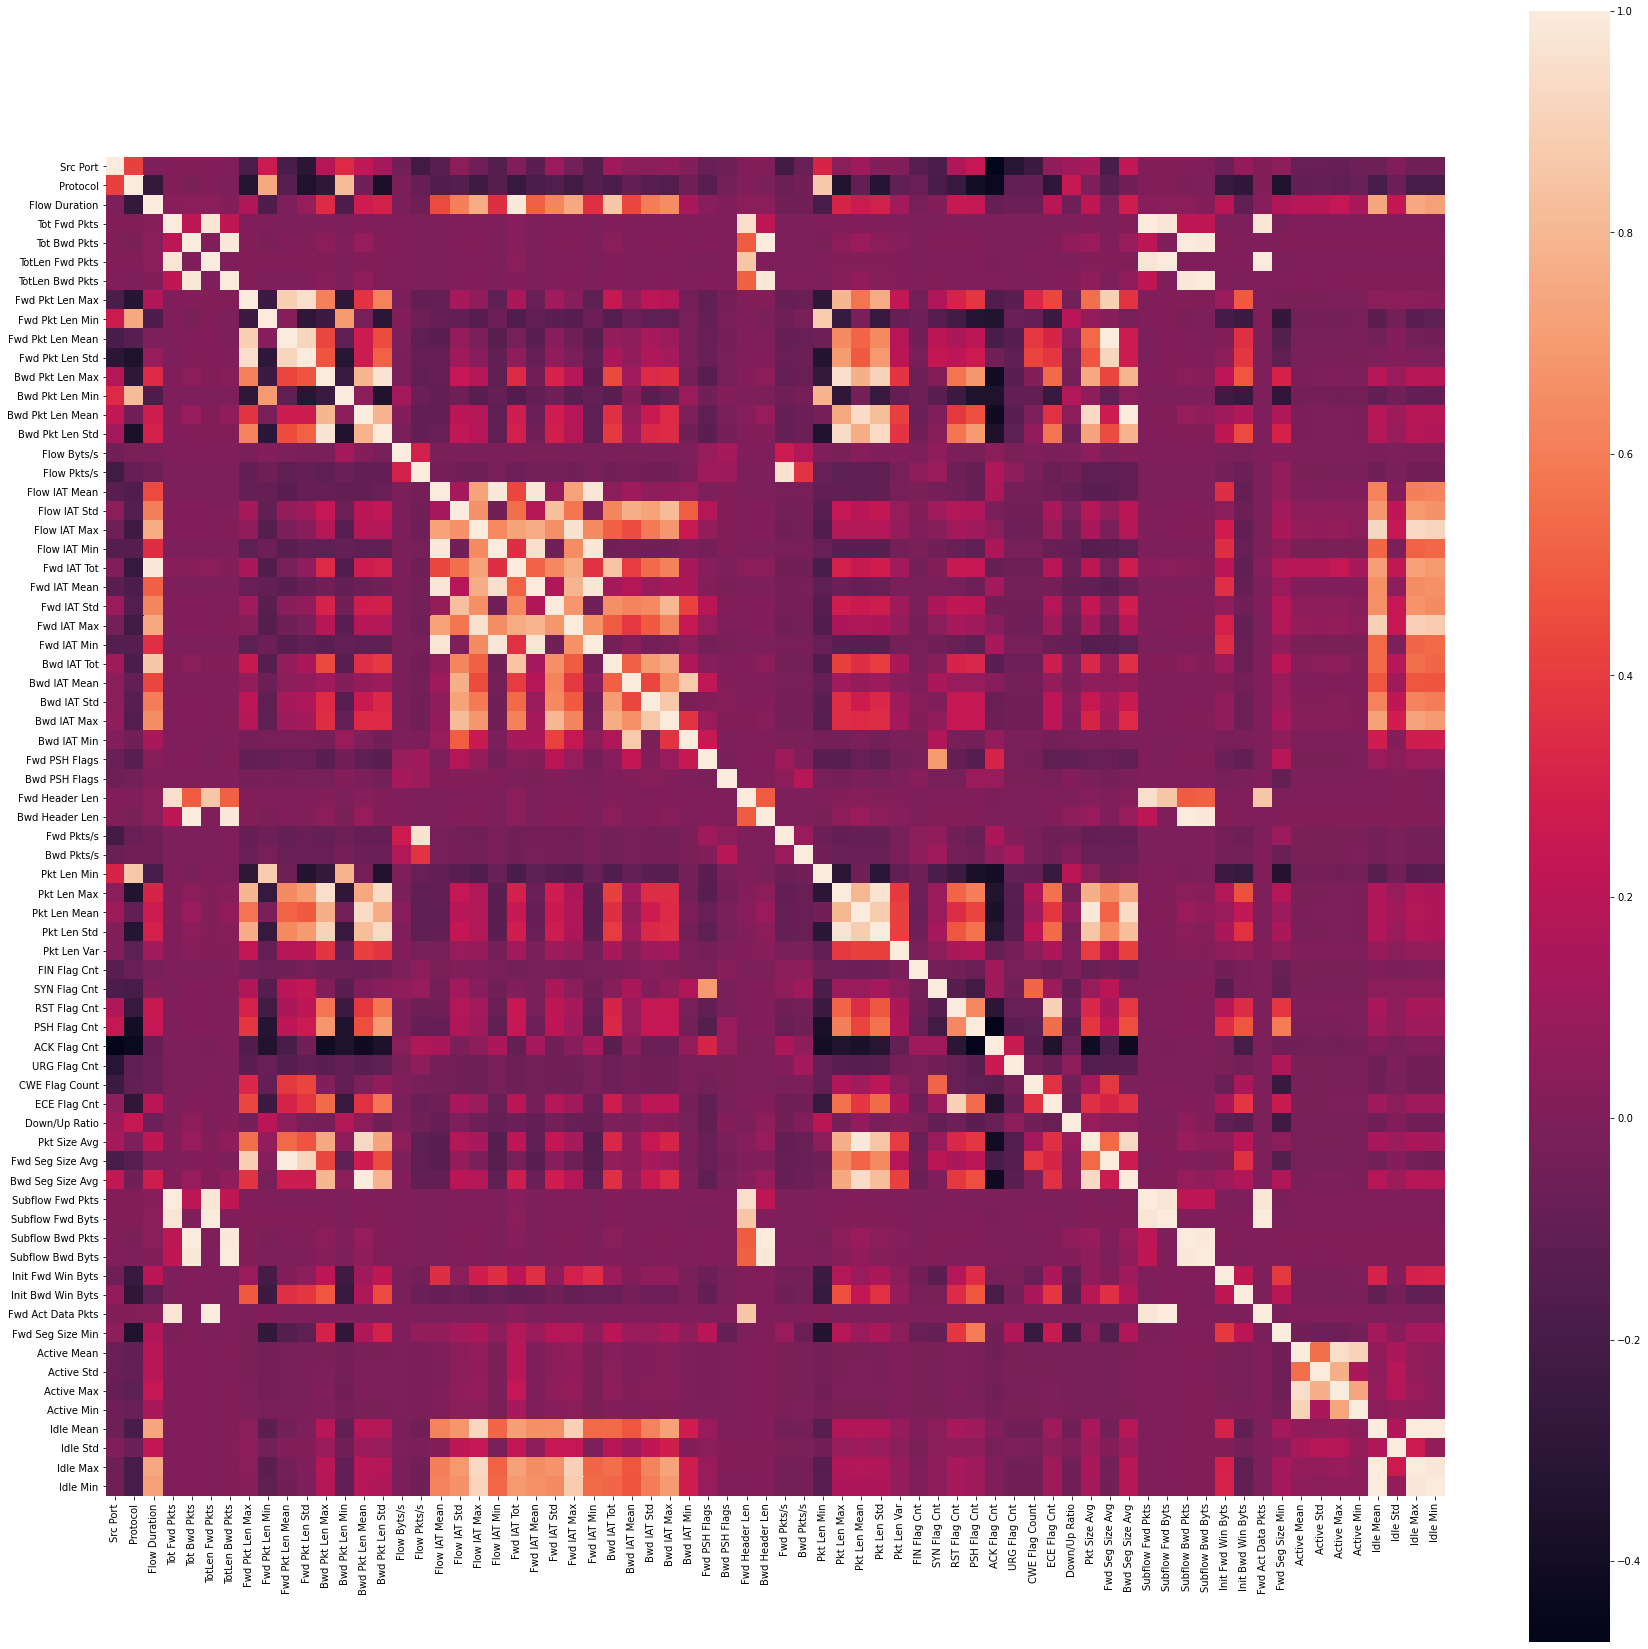

In [15]:
correlation_matrix1 = df_reduced.corr()
fig = plt.figure(figsize=(30,30))
sns.heatmap(correlation_matrix1,square = True)
plt.show()

In [16]:
#Lets find max correlated columns
max_correlation(correlation_matrix1, limit=0.99)

Flow Duration  |  Fwd IAT Tot 0.9904361062496507
Tot Fwd Pkts  |  Subflow Fwd Pkts 1.0
Tot Bwd Pkts  |  Bwd Header Len 0.9999214737457329
Tot Bwd Pkts  |  Subflow Bwd Pkts 1.0
TotLen Fwd Pkts  |  Subflow Fwd Byts 1.0
TotLen Fwd Pkts  |  Fwd Act Data Pkts 0.9978612054941117
TotLen Bwd Pkts  |  Subflow Bwd Byts 1.0
Fwd Pkt Len Mean  |  Fwd Seg Size Avg 1.0
Bwd Pkt Len Mean  |  Bwd Seg Size Avg 0.9999999999999999
Bwd Header Len  |  Subflow Bwd Pkts 0.9999214737457329
Pkt Len Mean  |  Pkt Size Avg 0.9926840992389903
Subflow Fwd Byts  |  Fwd Act Data Pkts 0.9978612054941117
Idle Mean  |  Idle Max 0.9946393508081165
Idle Mean  |  Idle Min 0.9953000943980415


In [51]:
#Dropping max corelated columns 
corr = df_reduced.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
col = corr.columns
remove_col = []
for i in tqdm(range(corr.shape[0])):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                remove_col.append(col[j])

print('No. of correlated columns:\n',len(remove_col))
print('\nRemoving following correlated columns:\n',np.array(remove_col))



No. of correlated columns:
 28

Removing following correlated columns:
 ['Fwd IAT Tot' 'TotLen Fwd Pkts' 'Fwd Header Len' 'Subflow Fwd Pkts'
 'Subflow Fwd Byts' 'Fwd Act Data Pkts' 'TotLen Bwd Pkts' 'Bwd Header Len'
 'Subflow Bwd Pkts' 'Subflow Bwd Byts' 'Fwd Pkt Len Std'
 'Fwd Seg Size Avg' 'Bwd Pkt Len Std' 'Pkt Len Max' 'Pkt Len Std'
 'Pkt Len Mean' 'Pkt Size Avg' 'Bwd Seg Size Avg' 'Fwd Pkts/s'
 'Flow IAT Min' 'Fwd IAT Mean' 'Fwd IAT Min' 'Fwd IAT Max' 'Idle Mean'
 'Idle Max' 'Idle Min' 'Active Max' 'Active Min']


In [22]:
print(len(df_reduced.columns))

72


In [24]:
print(remove_col)
print(len(remove_col))

['Fwd IAT Tot', 'TotLen Fwd Pkts', 'Fwd Header Len', 'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Act Data Pkts', 'TotLen Bwd Pkts', 'Bwd Header Len', 'Subflow Bwd Pkts', 'Subflow Bwd Byts', 'Fwd Pkt Len Std', 'Fwd Seg Size Avg', 'Bwd Pkt Len Std', 'Pkt Len Max', 'Pkt Len Std', 'Pkt Len Mean', 'Pkt Size Avg', 'Bwd Seg Size Avg', 'Fwd Pkts/s', 'Flow IAT Min', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Max', 'Idle Mean', 'Idle Max', 'Idle Min', 'Active Max', 'Active Min']
28


In [25]:

#Dropping all highly correlated columns 
print("\noriginal Shape of data : "  ,df_reduced.shape )
df_final = df_reduced.drop(remove_col,axis=1)
print('\nDataframe shape after trimming :',df_final.shape)


original Shape of data :  (7616509, 72)

Dataframe shape after trimming : (7616509, 44)


In [26]:
df_final['y'] = Target.apply(lambda x: 1 if x=='ddos' else 0)

df_final['y']


0          1
1          1
2          1
3          1
4          1
          ..
7616504    0
7616505    0
7616506    0
7616507    0
7616508    0
Name: y, Length: 7616509, dtype: int64

In [27]:

df_final['Src IP'] = df['Src IP'].apply(lambda x: int(('').join(x.split('.'))))
df_final['Dst IP'] = df['Dst IP'].apply(lambda x: int(('').join(x.split('.'))))

In [34]:
df_final.head(10)
df["Label"] = Target
print(df["Label"] )

0            ddos
1            ddos
2            ddos
3            ddos
4            ddos
            ...  
7616504    Benign
7616505    Benign
7616506    Benign
7616507    Benign
7616508    Benign
Name: Label, Length: 7616509, dtype: object


### Observation on Data - 


Src IP' count for DDoS:
172.31.69.25      353087
18.219.193.20     348970
172.31.69.28      183862
18.218.229.235     37035
18.216.200.189     36992
18.218.11.51       36770
18.219.9.1         36758
18.216.24.42       36721
18.219.5.43        36460
52.14.136.135      36402
Name: Src IP, dtype: int64 



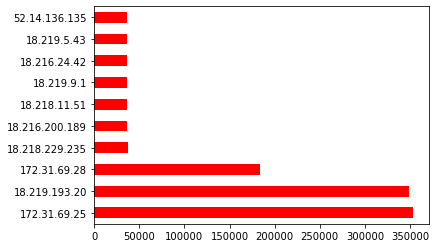

In [37]:
# Lets find what are Top 10 Source IP addresses for DDoS attacks
scrIP_col = 'Src IP'
ddos = df[df['Label']=='ddos'][scrIP_col].value_counts().nlargest(10)
print(scrIP_col +'\''+' count for DDoS:')
print(ddos,'\n')
ddos.plot(kind='barh',color='red')
plt.show()


Src IP' count for Benign:
8.6.0.1          75213
192.168.10.3     54116
192.168.10.25    46393
192.168.10.5     39035
212.92.116.6     35115
212.92.114.68    32859
37.46.246.28     32847
77.72.83.21      32491
192.168.10.12    29133
192.168.10.9     27477
Name: Src IP, dtype: int64 



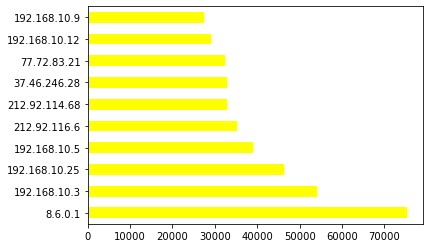

In [40]:
# Lets find what are Top 10 Source IP addresses for Benign attacks
benign = df[df['Label']=='Benign'][scrIP_col].value_counts().nlargest(10)
print(scrIP_col +'\''+' count for Benign:')
print(benign,'\n')
benign.plot(kind='barh',color='yellow')
plt.show()



Src Port' count for DDoS:
80       536620
55322        76
54376        75
54142        74
57324        74
57328        74
55716        74
52532        73
58280        73
58320        73
Name: Src Port, dtype: int64 



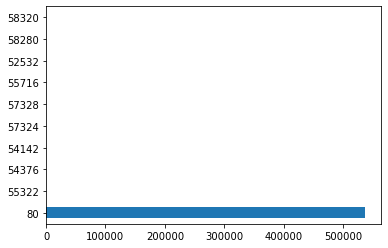

In [45]:
# Lets find what are Top 10 Source portgroup for DDoS attacks
colName = 'Src Port'
ddos = df[df['Label']=='ddos'][colName].value_counts().nlargest(10)
print(colName +'\''+' count for DDoS:')
print(ddos,'\n')
ddos.plot(kind='barh')
plt.show()



Src Port' count for Benign:
443      573315
445      168045
80       137870
0        115544
3389      64093
49672     17836
123       11888
49673      8714
68         6499
137        4692
Name: Src Port, dtype: int64 



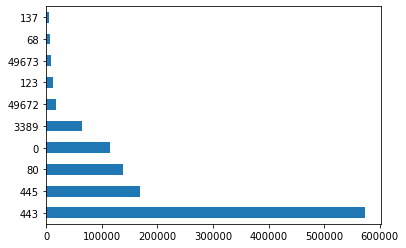

In [44]:
# Lets find what are Top 10 Source portgroup for benigh attacks
colName = 'Src Port'
benign = df[df['Label']=='Benign'][colName].value_counts().nlargest(10)
print(colName +'\''+' count for Benign:')
print(benign,'\n')
benign.plot(kind='barh')
plt.show()

Observation:
1.Source Port 80 is most used for DDoS attack which is standard Port No. for HTTP protocol.
2.Source Port 443 is most used for Benign traffic which is standart Port No. 

Protocol' count for DDoS:
6     1293706
17        823
Name: Protocol, dtype: int64 



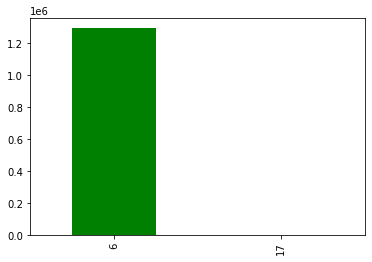

In [49]:
# Lets find what are Top Protocols portgroup for DDoS attacks
colName = 'Protocol'
ddos = df[df['Label']=='ddos'][colName].value_counts().nlargest(10)
print(colName +'\''+' count for DDoS:')
print(ddos,'\n')
ddos.plot(kind='bar',color='green')
plt.show()

Protocol' count for Benign:
6     4020622
17    2185816
0      115542
Name: Protocol, dtype: int64 



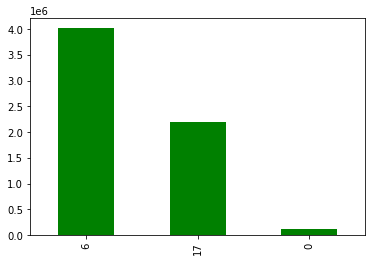

In [50]:
# Lets find what are Top Protocol for benigh attacks
colName = 'Protocol'
benign = df[df['Label']=='Benign'][colName].value_counts().nlargest(10)
print(colName +'\''+' count for Benign:')
print(benign,'\n')
benign.plot(kind='bar',color='green')
plt.show()

Observation:
1.Protocol 6 (TCP: Transfer Control Protocol) and 17 
(UDP: User Datagram Protocol) is used for DDoS attacks.
2. Protocol 0 is IPv6 Hop-by-Hop Option Protocol which is the least used protocol among all.


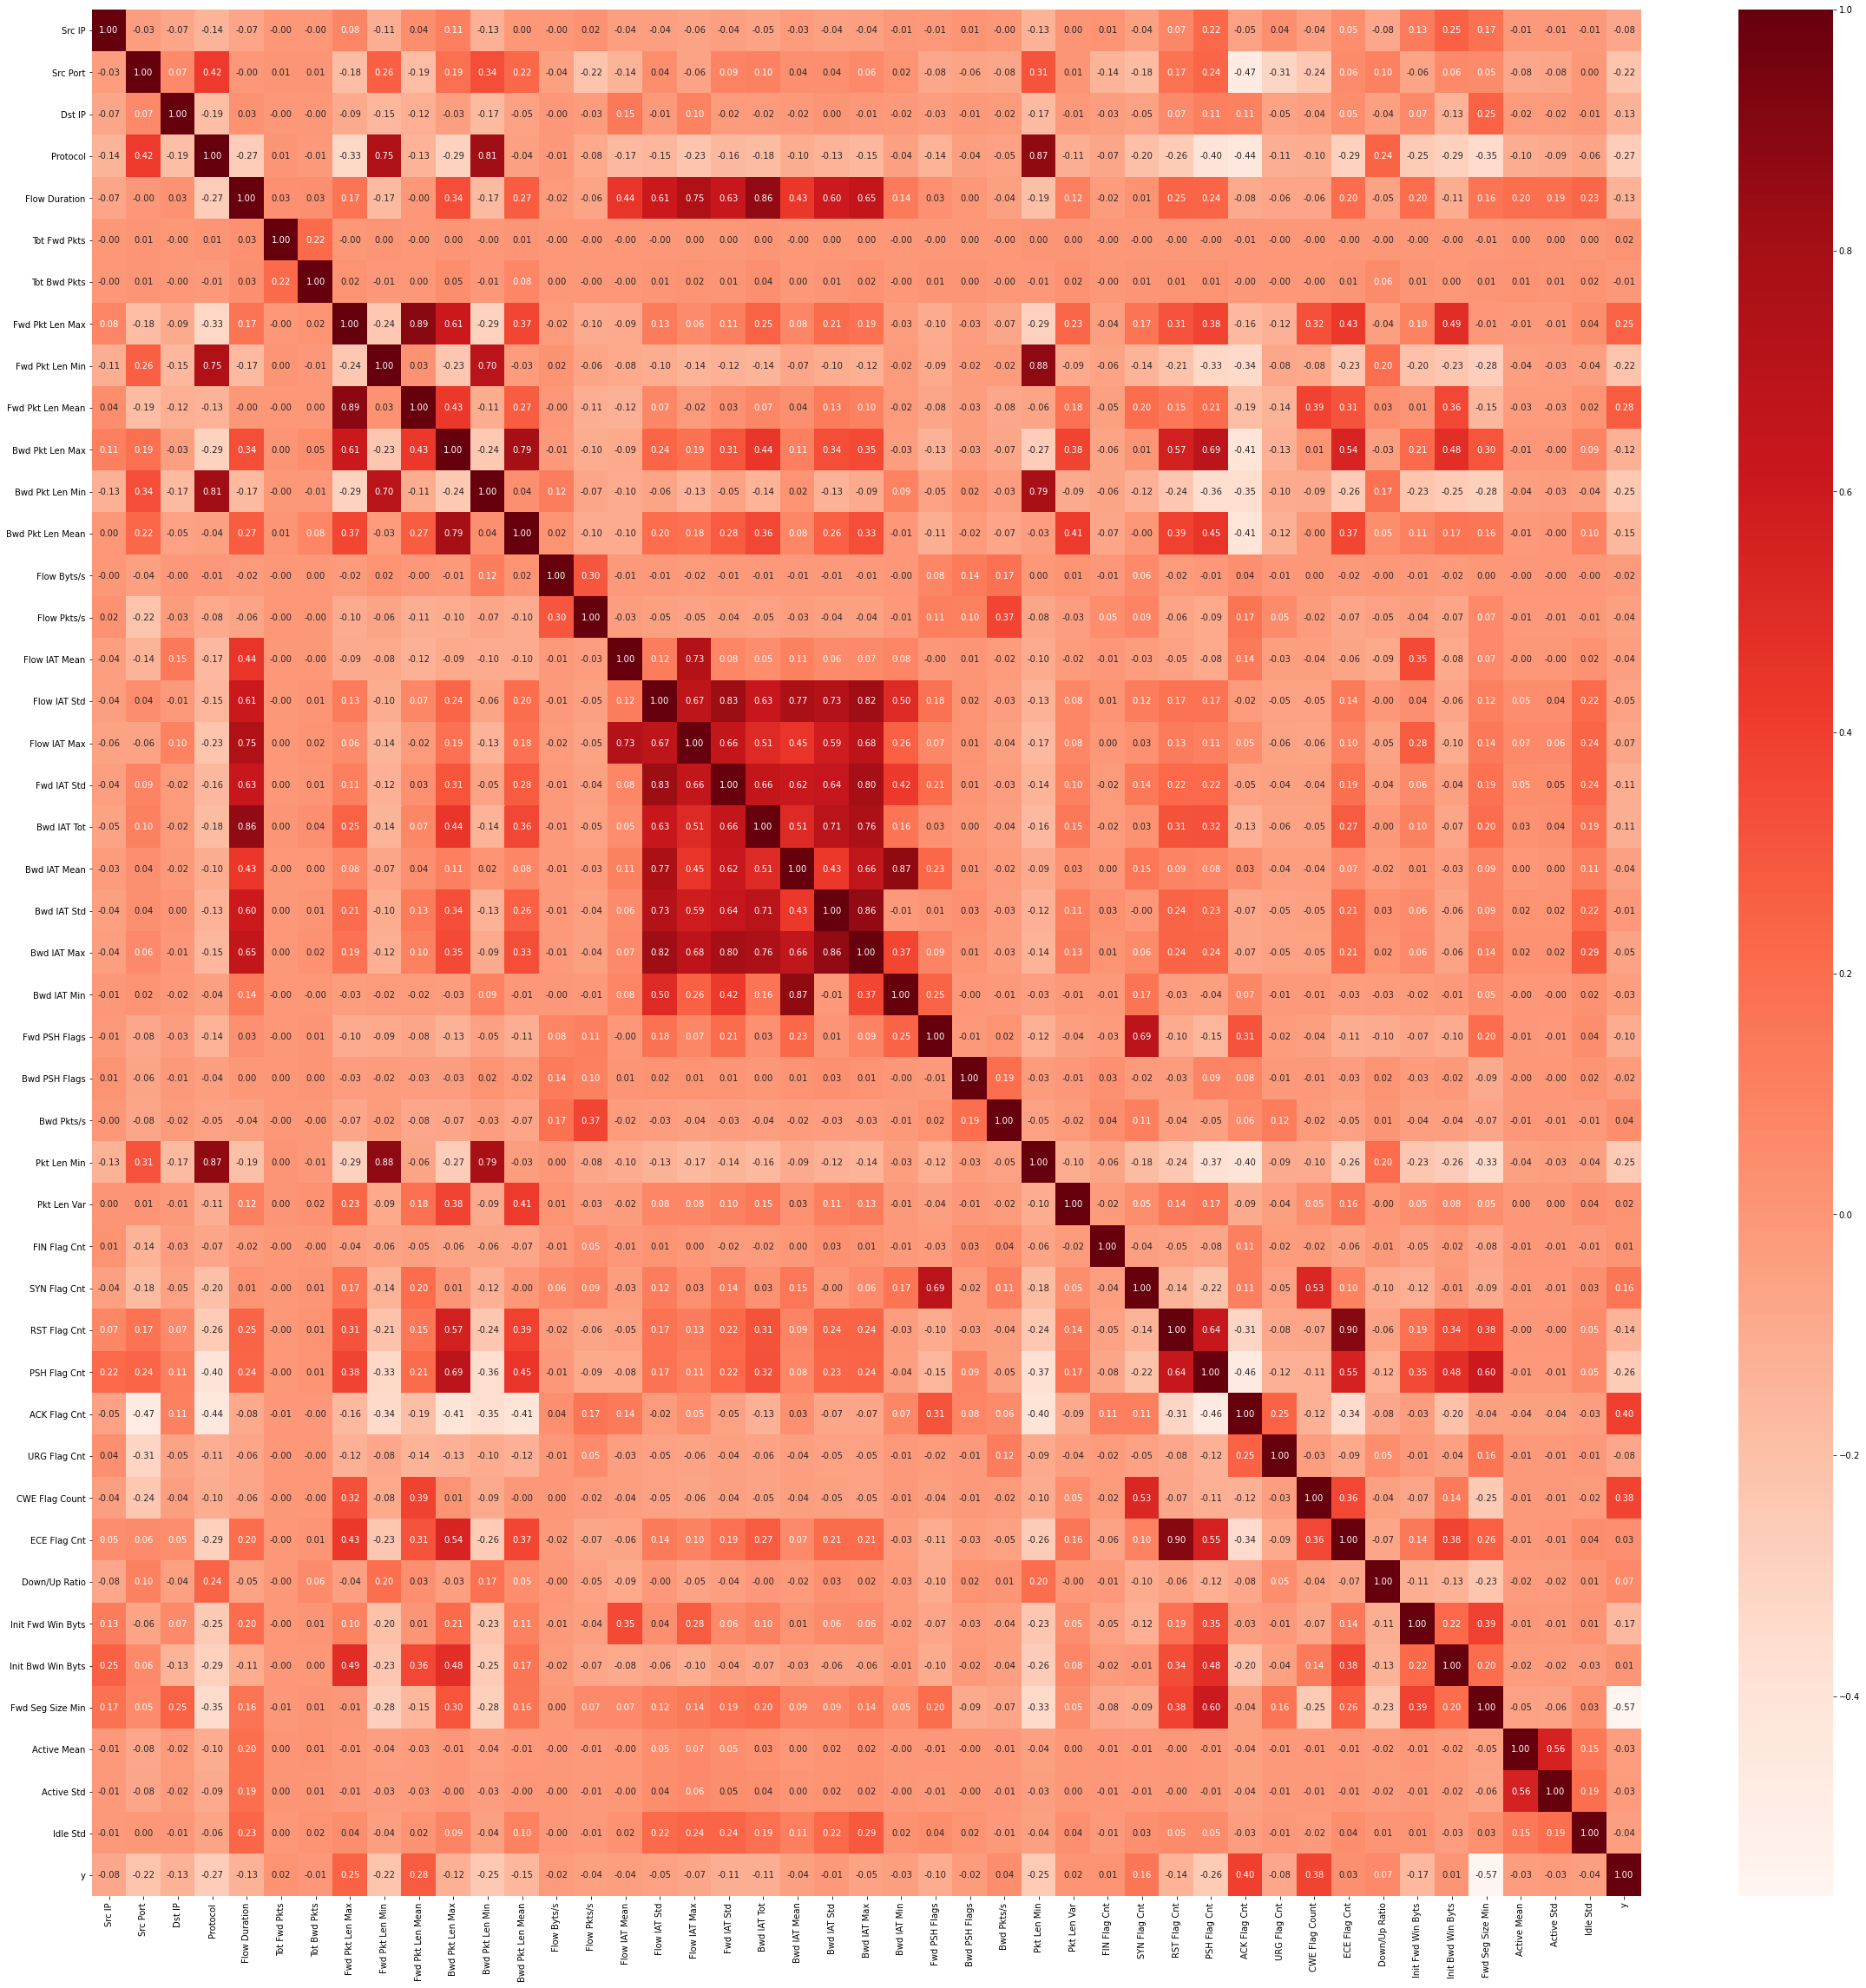

In [31]:
# Lets double check more correlated columns after reducing the dataset to 46 columns 
df_corr = df_final.corr()

plt.figure(figsize=(40,40))
sns.heatmap(df_corr, annot=True, cmap=plt.cm.Reds,fmt='.2f')
plt.show()

# # EDA Observations 
1.We still have many highly correlated data but since due to low dimentionality of dataset, lets keep them.
2. We have found Top 10 Source IP , Source protocol for both DDOS and BENIGN

In [29]:
#most of the data cleaing is done , lets save this dataframe in a csv file as clean data .
# saving the dataframe 
df_final.to_csv('Project_final_clean_data.csv') 